In [2]:
import io
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from dataclasses import dataclass
from time import time
from typing import Callable, Any

import utils
from decoder import Decoder as BruteForceDecoder
from jit_bfencoder import JitedBruteForceEncoder
from quadtree.encoder import QuadtreeEncoder
from quadtree.decoder import QuadtreeDecoder

In [3]:
def load_img(path: str) -> np.ndarray:
    return utils.load_grayscale(path)

def kalafior(size: int) -> np.ndarray:
    return load_img(f'../imgs/raw/cauliflower_{size}x{size}_colored.png')

def lena(size: int):
    return load_img(f'../imgs/raw/lena_{size}x{size}_grayscale.bmp')

def show_img(img: np.ndarray, ax):
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
@dataclass
class CodecInfo:
    encoding: Any
    decoded_img: np.ndarray
    encoding_time: float
    decoding_time: float
    decoding_iterations: int

In [5]:
def encode_decode_jpeg(img: np.ndarray):
    with io.BytesIO() as bytes_io:
        start = time()
        Image.fromarray(img).save(bytes_io, format="JPEG")
        encoding_time = time() - start

        start = time()
        bytes_io.seek(0)
        decoded_img = np.asarray(Image.open(bytes_io))
        decoding_time = time() - start
    return CodecInfo(None, decoded_img, encoding_time, decoding_time, 0)

In [6]:
def encode_decode_bruteforce(img: np.ndarray, decoding_iterations=32, show_error_stats=False) -> CodecInfo:
    start = time()
    encoder = JitedBruteForceEncoder(img)
    encoded_img, errs = encoder.encode()
    encoding_time = time() - start

    start = time()
    decoder = BruteForceDecoder()
    decoded_img = decoder.decode(encoded_img, iterations=decoding_iterations)
    decoding_time = time() - start

    if show_error_stats:
        plt.hist(errs)

    return CodecInfo(encoded_img, decoded_img, encoding_time, decoding_time, decoding_iterations)

In [7]:
def encode_decode_quadtree(img: np.ndarray, encoder: QuadtreeEncoder=None, decoding_iterations=32) -> CodecInfo:
    if encoder is None:
        max_square = int(min(np.log2(img.shape[0]), np.log2(img.shape[1])))
        default_max_size = int(np.log2(32))
        default_min_size = int(np.log2(4))
        min_partitions = max_square - default_max_size
        max_partitions = max_square - default_min_size
        encoder = QuadtreeEncoder((-1., 1.), False, False, min_partitions, max_partitions, 2.)
    start = time()
    encoded_img = encoder.encode(img)
    encoding_time = time() - start

    start = time()
    decoded_img = QuadtreeDecoder().decode(img.shape[1], img.shape[0], encoded_img, decoding_iterations)
    decoding_time = time() - start

    return CodecInfo(encoded_img, decoded_img, encoding_time, decoding_time, decoding_iterations)

In [8]:
@dataclass
class Metrics:
    squared_error: float
    mse: float
    psnr: float
    encoding_time: str
    decoding_time: str

def compute_metrics(original_img: np.ndarray, codec_info: CodecInfo) -> Metrics:
    squared_error = np.linalg.norm(original_img.astype(np.int32) - codec_info.decoded_img.astype(np.int32))
    mse = squared_error / (original_img.shape[0] * original_img.shape[1])
    psnr = 10 * np.log10(255. / mse)
    return Metrics(squared_error, mse, psnr, f'{codec_info.encoding_time:.4f}s', f'{codec_info.decoding_time:.4f}s')

def compare_encoding(original_img: np.ndarray, codec_info: CodecInfo):
    jpeg_info = encode_decode_jpeg(original_img)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    imgs = [original_img, codec_info.decoded_img, jpeg_info.decoded_img]
    titles = [f"Original ({original_img.shape[1]}x{original_img.shape[0]})", "Fractal compressed", "JPEG compressed"]
    for ax, img, title in zip(axs, imgs, titles):
        show_img(img, ax)
        ax.set_title(title)
    plt.show()

    print('Fractal compression:')
    print(compute_metrics(original_img, codec_info))

    print('JPEG (PIL defaults):')
    print(compute_metrics(original_img, jpeg_info))

In [9]:
def compare_per_iteration_results(decoder: Callable[[int], tuple[np.ndarray, float]]):
    iters = [1, 2, 4, 8, 16, 32]
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    results = []
    for i, it_num in enumerate(iters):
        decoded_img, err = decoder(it_num)
        ax = axs[i//3][i%3]
        show_img(decoded_img, ax)
        ax.set_title(f'{it_num} iterations')
        results.append(err)
    plt.show()

    plt.plot(iters, results)
    plt.title("| original - decoded |")
    plt.ylabel('error')
    plt.xlabel('iterations')
    # plt.xscale('log')
    plt.show()

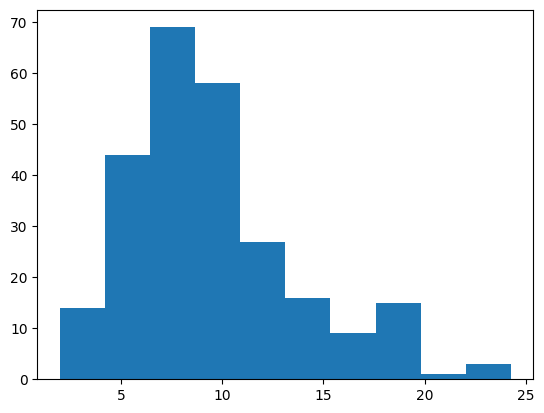

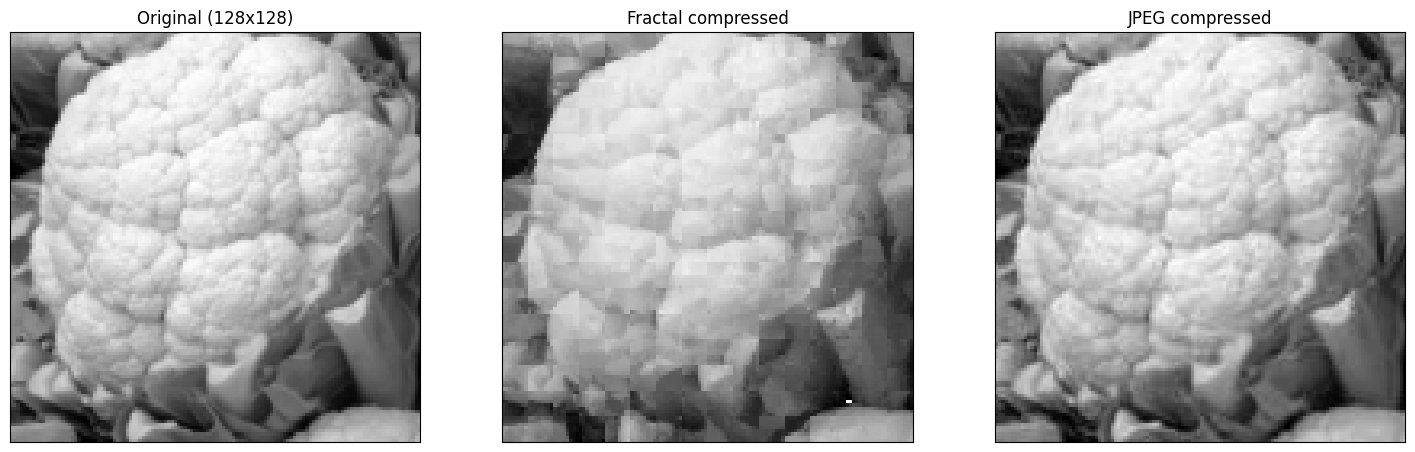

Fractal compression:
Metrics(squared_error=1411.7712279261114, mse=0.08616767748572457, psnr=34.711957930556004, encoding_time='16.1182s', decoding_time='0.0721s')
JPEG (PIL defaults):
Metrics(squared_error=541.4065016233181, mse=0.0330448304213451, psnr=38.87436652923619, encoding_time='0.0001s', decoding_time='0.0001s')


In [25]:
img = kalafior(128)
bruteforce_encoding = encode_decode_bruteforce(img, show_error_stats=True)
compare_encoding(img, bruteforce_encoding)

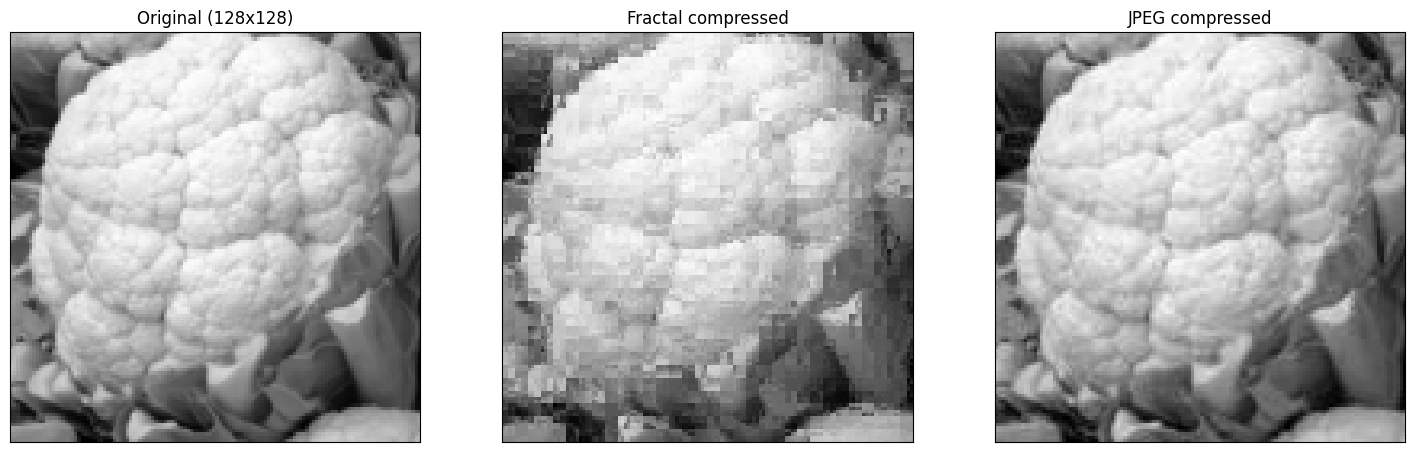

Fractal compression:
Metrics(squared_error=1857.8753994818921, mse=0.11339571530040846, psnr=33.519435355467735, encoding_time='0.0191s', decoding_time='0.2823s')
JPEG (PIL defaults):
Metrics(squared_error=541.4065016233181, mse=0.0330448304213451, psnr=38.87436652923619, encoding_time='0.0001s', decoding_time='0.0001s')


In [16]:
img = kalafior(128)
quadtree_info = encode_decode_quadtree(img)
compare_encoding(img, quadtree_info)

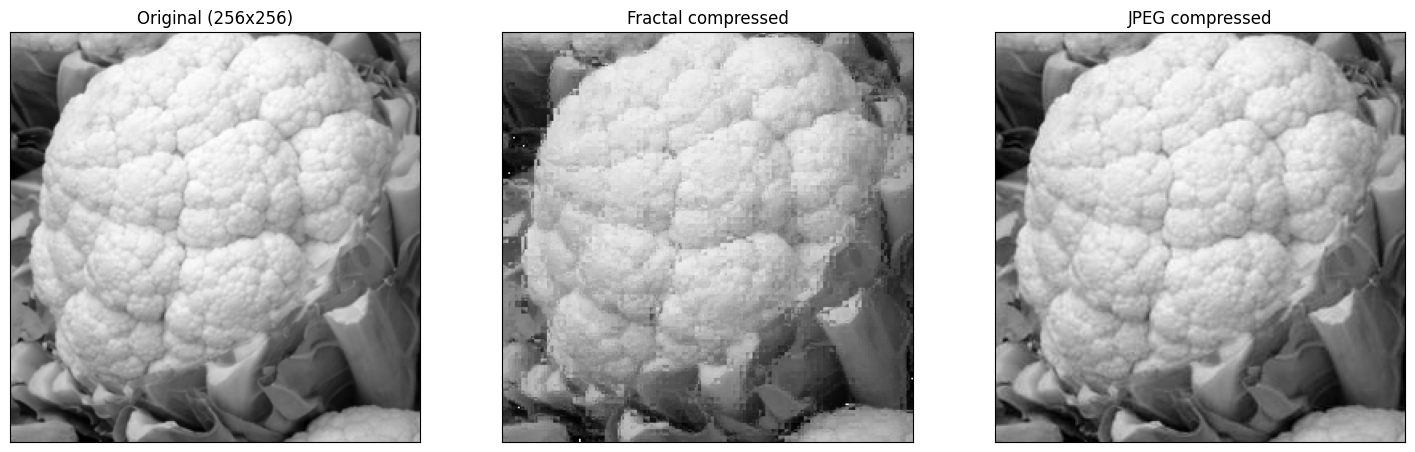

Fractal compression:
Metrics(squared_error=3145.332891762015, mse=0.04799397112673973, psnr=37.25353494534085, encoding_time='0.1994s', decoding_time='1.1116s')
JPEG (PIL defaults):
Metrics(squared_error=810.6022452473222, mse=0.012368808673817783, psnr=43.142123087193724, encoding_time='0.0002s', decoding_time='0.0002s')


In [17]:
img = kalafior(256)
quadtree_info = encode_decode_quadtree(img)
compare_encoding(img, quadtree_info)

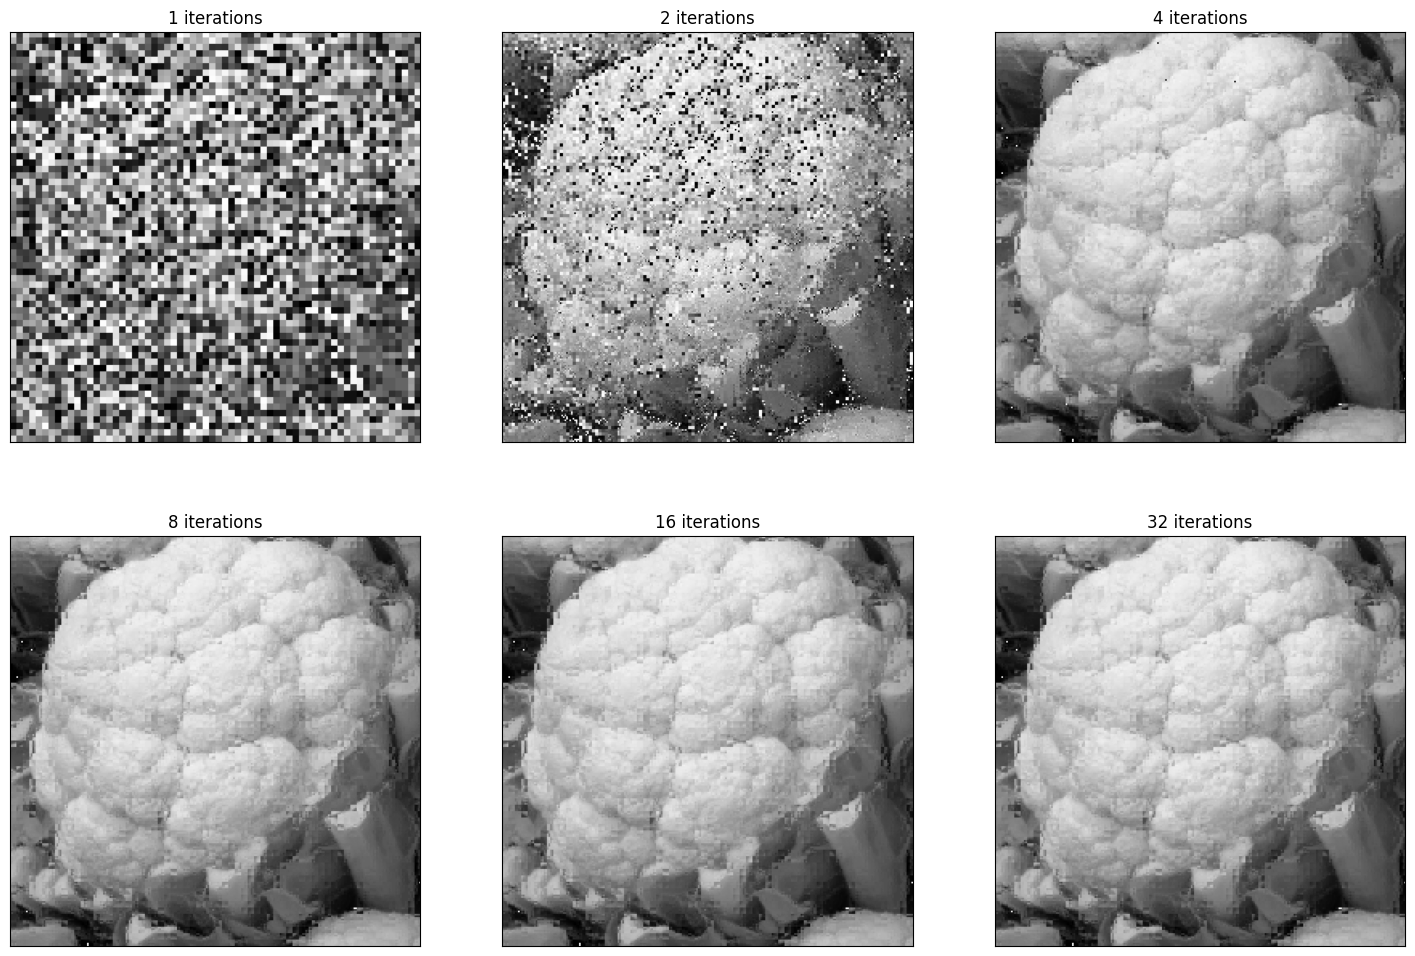

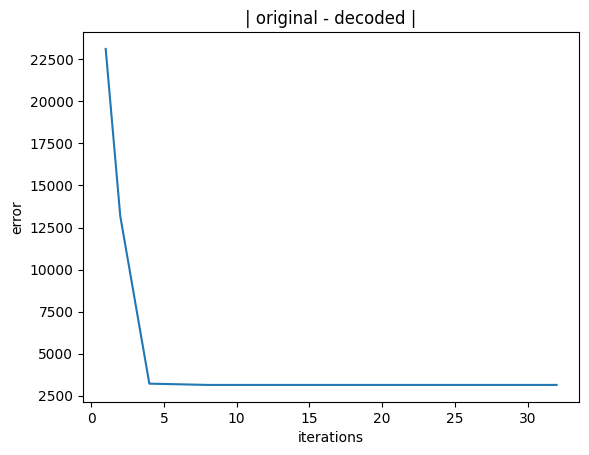

In [23]:
def it_decoder(it_num):
    decoded = QuadtreeDecoder().decode(img.shape[1], img.shape[0], quadtree_info.encoding, it_num)
    err = np.linalg.norm(img.astype(np.int32) - decoded.astype(np.int32))
    return decoded, err
compare_per_iteration_results(it_decoder)

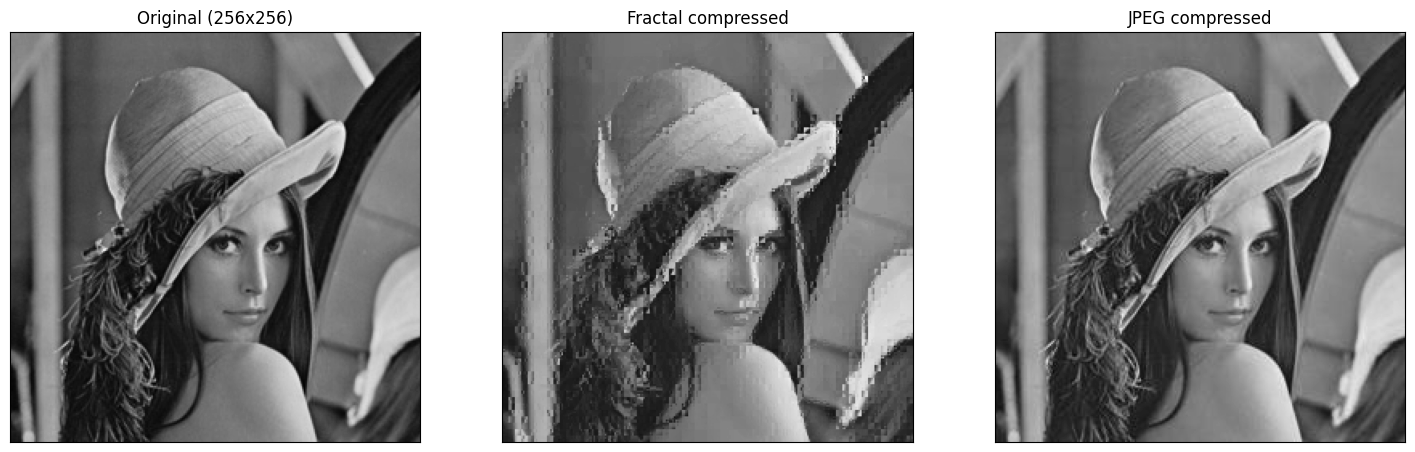

Fractal compression:
Metrics(squared_error=3730.330682392648, mse=0.0569203290160011, psnr=36.5127277866646, encoding_time='0.1773s', decoding_time='1.0080s')
JPEG (PIL defaults):
Metrics(squared_error=913.2283394639043, mse=0.01393475859777686, psnr=42.62440730926902, encoding_time='0.0002s', decoding_time='0.0002s')


In [24]:
img = lena(256)
quadtree_info = encode_decode_quadtree(img)
compare_encoding(img, quadtree_info)

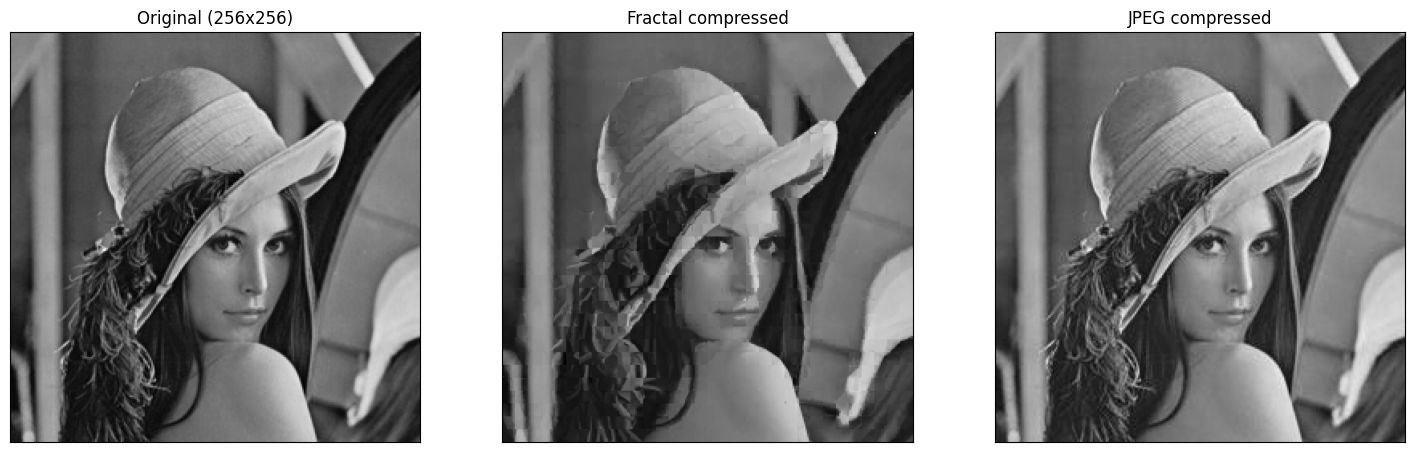

Fractal compression:
Metrics(squared_error=2065.421022455228, mse=0.0315158237068974, psnr=39.080115179748496, encoding_time='291.4619s', decoding_time='0.2795s')
JPEG (PIL defaults):
Metrics(squared_error=913.2283394639043, mse=0.01393475859777686, psnr=42.62440730926902, encoding_time='0.0002s', decoding_time='0.0002s')


In [33]:
img = lena(256)
bruteforce_info = encode_decode_bruteforce(img)
compare_encoding(img, bruteforce_info)

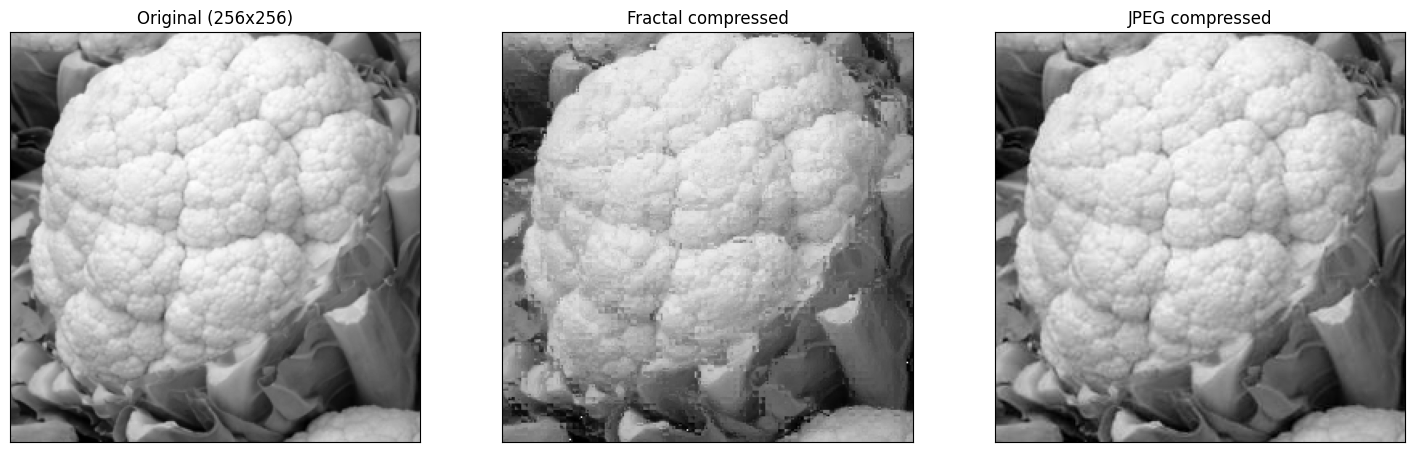

Fractal compression:
Metrics(squared_error=2901.4959934488966, mse=0.044273315329725595, psnr=37.603981358552744, encoding_time='4.1196s', decoding_time='1.1661s')
JPEG (PIL defaults):
Metrics(squared_error=810.6022452473222, mse=0.012368808673817783, psnr=43.142123087193724, encoding_time='0.0002s', decoding_time='0.0002s')


In [26]:
img = kalafior(256)
quadtree_info = encode_decode_quadtree(img, encoder=QuadtreeEncoder((-1., 1.), False, True, 4, 6, 2.))
compare_encoding(img, quadtree_info)

In [31]:
def find_kalafior_encoding_params():
    img = kalafior(256)

    def f(min_partition_size, max_partition_size, error_tolerance):
        encoder = QuadtreeEncoder(1, False, False, min_partition_size, max_partition_size, error_tolerance)
        quadtree_info = encode_decode_quadtree(img, encoder=encoder)
        metrics = compute_metrics(img, quadtree_info)
        return metrics.mse # minimize mse = maximize psnr
    
    err_tol_range = np.linspace(1, 10, 20)

    min_err = np.inf
    best_params = None

    for min_part in range(3, 5):
        for max_part in range(min_part + 2, 7):
            for err_tol in err_tol_range:
                err = f(min_part, max_part, err_tol)
                if err < min_err:
                    min_err = err
                    best_params = (min_part, max_part, err_tol)
    return min_err, best_params

In [32]:
find_kalafior_encoding_params()

(0.04799336956825079, (3, 6, 1.9473684210526314))

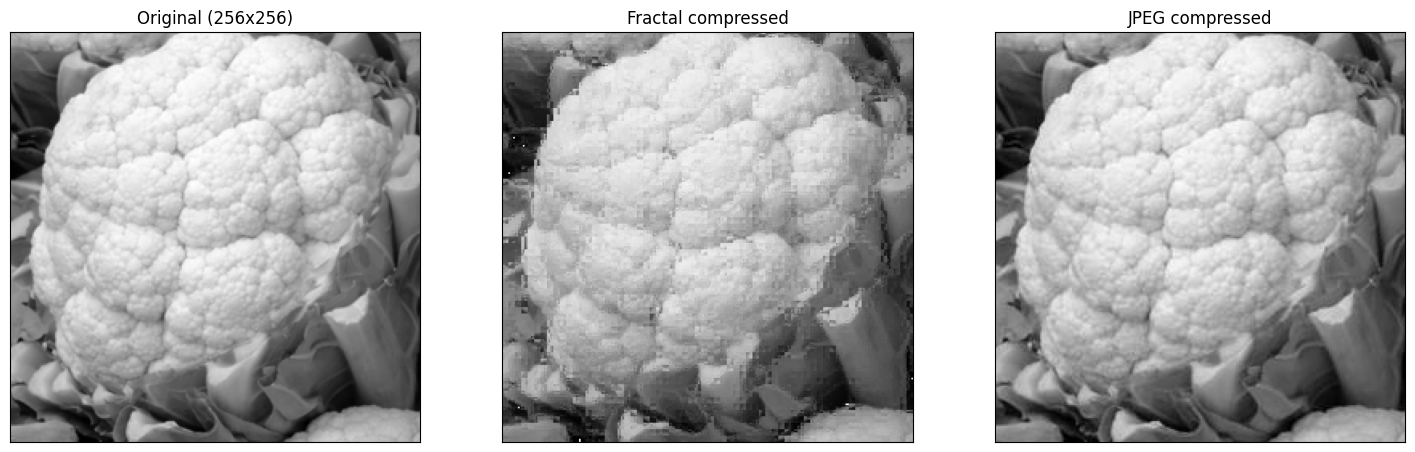

Fractal compression:
Metrics(squared_error=3145.2934680248836, mse=0.04799336956825079, psnr=37.2535893803383, encoding_time='0.1312s', decoding_time='1.1300s')
JPEG (PIL defaults):
Metrics(squared_error=810.6022452473222, mse=0.012368808673817783, psnr=43.142123087193724, encoding_time='0.0002s', decoding_time='0.0002s')


In [21]:
img = kalafior(256)
quadtree_info = encode_decode_quadtree(img, encoder=QuadtreeEncoder((-1., 1.), False, False, 3, 6, 1.947))
compare_encoding(img, quadtree_info)

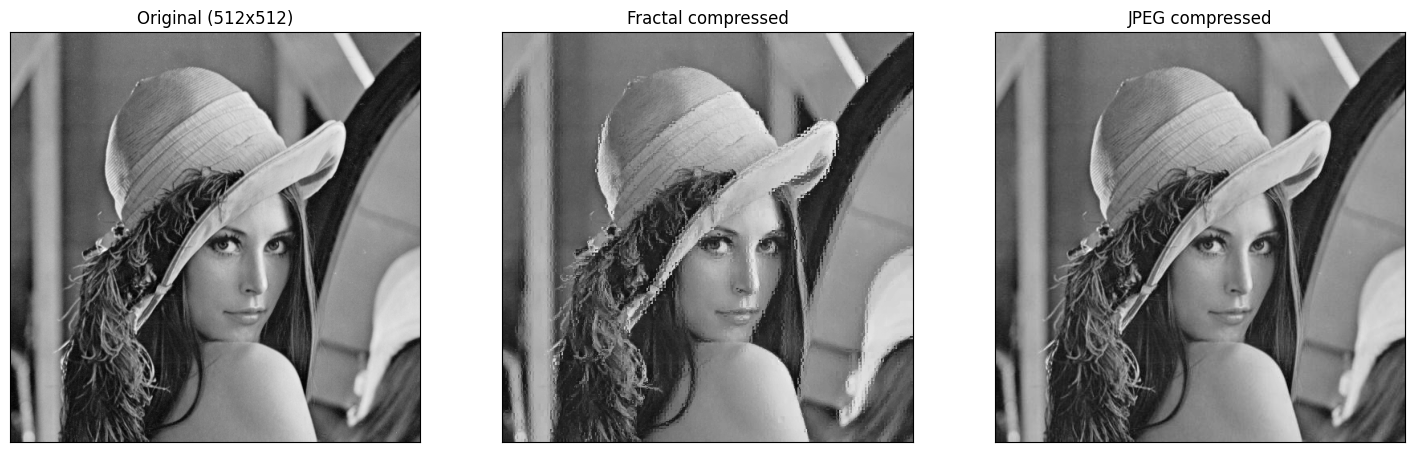

Fractal compression:
Metrics(squared_error=6087.516652954635, mse=0.023222033130472698, psnr=40.406399401093054, encoding_time='2.1584s', decoding_time='4.4771s')
JPEG (PIL defaults):
Metrics(squared_error=1675.4996269769802, mse=0.006391523845584794, psnr=46.00935766902991, encoding_time='0.0005s', decoding_time='0.0005s')


In [26]:
img = load_img(f'../imgs/raw/lena_512x512_colored.bmp')
quadtree_info = encode_decode_quadtree(img)
compare_encoding(img, quadtree_info)